In [1]:
import ROOT as r
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import sys
import os
sys.path.append(os.getcwd()+ '/../utilities/')
from milliqanProcessor import *
from milliqanScheduler import *
from milliqanCuts import *
from milliqanPlotter import *

In [2]:
newCalibrations = [-15.65, -15.45, -15.54, -14.14, -25.00, -20.61, -20.26, -18.80, 
                   -13.99, -14.42, -16.72, -16.20, -17.38, -23.36, -24.32, -19.14, 
                   -10.15, -11.64, -12.31, -13.35, -14.11, -18.87, -15.29, -14.54, 
                   0, 0, -6.10, -8.59, -9.66, -16.66, -15.18, -13.45, 
                   4.13, 2.57, 3.41, 3.32, 0.77, -3.34, -2.22, -4.28, 
                   5.23, 4.58, 1.29, 4.03, 0.49, -2.68, -3.21, -4.38, 
                   12.74, 11.98, 12.43, 12.50, 3.64, 7.24, 5.95, -2.35, 
                   11.92, 11.51, 6.50, 6.21, 1.64, 0.80, 1.44, -0.27, 
                   0, 0, 0, 0, 8.67, 25.98, 8.13, 18.82,
                   5.68, 10.21, 0, 16.54, 0, 0, -4.70, -7.77]

In [3]:
f_cal = open('../../configuration/barConfigs/configRun1296_present.json')
oldCalibrations = json.load(f_cal)['timingCalibrations']

newCalibrations = np.array(newCalibrations)
oldCalibrations = np.array(oldCalibrations)

In [4]:
diffs = oldCalibrations - newCalibrations
channels = np.arange(80)

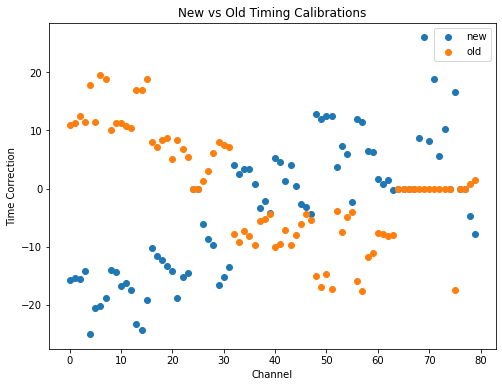

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(channels, newCalibrations, label='new')
plt.scatter(channels, oldCalibrations, label='old')
plt.title('New vs Old Timing Calibrations')
plt.xlabel('Channel')
plt.ylabel('Time Correction')
plt.legend()

Text(0, 0.5, 'Old - New Calibration')

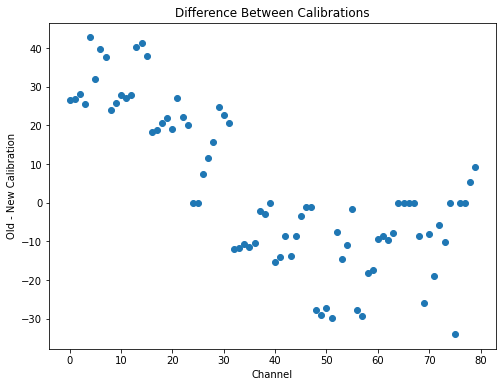

In [8]:
plt.figure(figsize=(8, 6))

plt.scatter(channels, diffs)
plt.title('Difference Between Calibrations')
plt.xlabel('Channel')
plt.ylabel('Old - New Calibration')

In [83]:
@mqCut
def timeDiffFrontPanel(self):

    frontPanelMask = ak.any(self.events['chan']==74, axis=1)
    backPanelMask = ak.any(self.events['chan']==75, axis=1)

    frontPanelMask = frontPanelMask & backPanelMask
    
    _, allTimesMask = ak.broadcast_arrays(self.events['timeFit'], frontPanelMask)
    allTimes = ak.mask(self.events['timeFit'], allTimesMask)
    allChannels = ak.mask(self.events['chan'], allTimesMask)
    allLayers = ak.mask(self.events['layer'], allTimesMask)
    
    frontPanelTimes = self.events['timeFit'][(self.events['chan'] == 74) & (frontPanelMask)]

    frontPanelTimes = ak.pad_none(frontPanelTimes, 1)
    frontPanelTimes = ak.flatten(frontPanelTimes)

    
    #print("front", len(frontPanelTimes), frontPanelTimes)
    #print("all", len(allTimes), allTimes)

    # Use ak.cartesian to match the structures
    #single_broadcasted = ak.zip({"single": frontPanelTimes, "multi": allTimes})
    
    # Expand the single_value array to match the structure of multiple_values
    #frontPanelTimes = ak.unzip(single_broadcasted)[0]

    timeDiffs = frontPanelTimes - allTimes
    #print(ak.drop_none(ak.flatten(timeDiffs)))

    allTimeCombos = ak.combinations(allTimes, 2)
    allLayerCombos = ak.combinations(allLayers, 2)
    #maxLayer = ak.argmax(allLayerCombos, axis=-1)
    allTimeDiffs = ak.where(allLayerCombos['0'] > allLayerCombos['1'], allTimeCombos['0']-allTimeCombos['1'], allTimeCombos['1']-allTimeCombos['0'])
    #print("All Time Differences:", allTimeDiffs)

    #print('sidebandRMS', len(self.events['sidebandRMS']), len(self.events['sidebandRMS'][0]))
    _, newCals = ak.broadcast_arrays(self.events['sidebandRMS'], ak.Array([newCalibrations]))
    _, oldCals = ak.broadcast_arrays(self.events['sidebandRMS'], ak.Array([oldCalibrations]))

    allTimesNew = allTimes - newCals[allChannels]
    timeDiffsNew = frontPanelTimes - allTimesNew
    allTimeCombosNew = ak.combinations(allTimesNew, 2)
    allTimeDiffsNew = ak.where(allLayerCombos['0'] > allLayerCombos['1'], allTimeCombosNew['0']-allTimeCombosNew['1'], allTimeCombosNew['1']-allTimeCombosNew['0'])

    allTimesOld = allTimes + oldCals[allChannels]
    timeDiffsOld = frontPanelTimes - allTimesOld
    allTimeCombosOld = ak.combinations(allTimesOld, 2)
    allTimeDiffsOld = ak.where(allLayerCombos['0'] > allLayerCombos['1'], allTimeCombosOld['0']-allTimeCombosOld['1'], allTimeCombosOld['1']-allTimeCombosOld['0'])

    self.events['timeDiff'] = timeDiffs
    self.events['timeDiffNewCorrected'] = timeDiffsNew
    self.events['timeDiffOldCorrected'] = timeDiffsOld
    self.events['allTimeDiffs'] = allTimeDiffs
    self.events['allTimeDiffsNew'] = allTimeDiffsNew
    self.events['allTimeDiffsOld'] = allTimeDiffsOld
    

@mqCut
def frontPanelMask(self, cutName='frontPanelMask', cut=False, branches=None):

    frontPanelMask = ak.any(self.events['chan'] == 74, axis=1)
    _, frontPanelMask = ak.broadcast_arrays(self.events['npulses'], frontPanelMask)

    self.events[cutName] = frontPanelMask
    
    if cut:
        self.cutBranches(branches, cutName)

@mqCut
def backPanelMask(self, cutName='backPanelMask', cut=False, branches=None):

    frontPanelMask = ak.any(self.events['chan'] == 75, axis=1)
    _, frontPanelMask = ak.broadcast_arrays(self.events['npulses'], frontPanelMask)

    self.events[cutName] = frontPanelMask
    
    if cut:
        self.cutBranches(branches, cutName)

In [84]:
if __name__ == "__main__":

    filelist = [
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1400_v35_beam_beamOn_tight.root',
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1500_v35_beam_beamOn_tight.root',
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1600_v35_beam_beamOn_tight.root',
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1700_v35_beam_beamOn_tight.root',
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1800_v35_beam_beamOn_tight.root',
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1900_v35_beam_beamOn_tight.root',
    ]

    print("Running on files {}".format(filelist))

    #define the necessary branches to run over
    branches = ['event', 'tTrigger', 'boardsMatched', 'pickupFlag', 'pickupFlagTight', 'fileNumber', 'runNumber', 'type', 'ipulse', 'nPE', 'chan',
                'time_module_calibrated', 'timeFit_module_calibrated', 'row', 'column', 'layer', 'height', 'area', 'npulses', 'timeFit', 'sidebandRMS']


    #define the milliqan cuts object
    mycuts = milliqanCuts()

    setattr(milliqanCuts, "timeDiffFrontPanel", timeDiffFrontPanel)
    setattr(milliqanCuts, 'frontPanelMask', frontPanelMask)
    setattr(milliqanCuts, 'backPanelMask', backPanelMask)
    
    #require pulses are not pickup
    pickupCut = getCutMod(mycuts.pickupCut, mycuts, 'pickupCut', tight=True, cut=True, branches=branches)

    #require that all digitizer boards are matched
    boardMatchCut = getCutMod(mycuts.boardsMatched, mycuts, 'boardMatchCut', cut=True, branches=branches)

    #greater than or equal to one hit per layer
    hitInAllLayers = getCutMod(mycuts.oneHitPerLayerCut, mycuts, 'hitInAllLayers', cut=True, branches=branches, multipleHits=False)

    #exactly one hit per layer
    oneHitPerLayer = getCutMod(mycuts.oneHitPerLayerCut, mycuts, 'oneHitPerLayer', cut=True, branches=branches, multipleHits=False)

    #four layer cut
    fourLayerCut = getCutMod(mycuts.fourLayerCut, mycuts, 'fourLayerCut', cut=True, branches=branches)

    #panel veto
    panelVeto = getCutMod(mycuts.panelVeto, mycuts, 'panelVeto', nPECut=40e3, cut=True, branches=branches)

    #nPE Cut
    nPECut = getCutMod(mycuts.nPECut, mycuts, 'nPECut', nPECut=100, cut=True, branches=branches)

    #area cut
    areaCut = getCutMod(mycuts.areaCut, mycuts, 'areaCut', areaCut=300000, cut=True, branches=branches)

    #first pulse cut
    firstPulseCut = getCutMod(mycuts.firstPulseCut, mycuts, 'firstPulseCut', cut=True, branches=branches)

    #require front panel has hit
    #frontPanelHit = getCutMod(mycuts.frontPanelHit, mycuts, 'frontPanelHit', cut=True, branches=branches)

    #require hit time is in trigger window
    centralTime = getCutMod(mycuts.centralTime, mycuts, 'centralTime', cut=True, branches=branches)

    straightLineCut = getCutMod(mycuts.straightLineCut, mycuts, 'straightLineCut', cut=True, branches=branches)
    threeLineCut = getCutMod(mycuts.threeInLine, mycuts, 'threeInLine', cut=True, pulseCut=False, branches=branches)

    frontPanelMask = getCutMod(mycuts.frontPanelMask, mycuts, 'frontPanelMask', cut=True, branches=branches)
    backPanelMask = getCutMod(mycuts.backPanelMask, mycuts, 'backPanelMask', cut=True, branches=branches)

    nbins = 100
    minx = -10
    maxx = 90
    
    h_timeDiffWide = r.TH2F('h_timeDiffWide', 'Timing Difference from Front Panel;Channel;dT', 100, -10, 90, 100, -50, 50)
    h_timeDiff = r.TH2F('h_timeDiff', 'Timing Difference from Front Panel;Channel;dT', 100, -10, 90, 100, -10, 10)
    h_timeDiffNew = r.TH2F('h_timeDiffNew', 'Timing Difference from Front Panel;Channel;dT', 100, -10, 90, 100, -50, 50)
    h_timeDiffOld = r.TH2F('h_timeDiffOld', 'Timing Difference from Front Panel;Channel;dT', 100, -10, 90, 100, -50, 50)
    h_timeDiffAll = r.TH2F('h_timeDiffAll', 'Timing Difference All Channels;Channel;dT', 100, -10, 90, 100, -50, 50)
    h_timeDiffAllNew = r.TH2F('h_timeDiffAllNew', 'Timing Difference All Channels;Channel;dT', 100, -10, 90, 100, -50, 50)
    h_timeDiffAllOld = r.TH2F('h_timeDiffAllOld', 'Timing Difference All Channels;Channel;dT', 100, -10, 90, 100, -50, 50)


    cutflow = [mycuts.totalEventCounter, mycuts.fullEventCounter, 
                boardMatchCut, 
                pickupCut, 
                firstPulseCut,
                nPECut,
                centralTime,
                #straightLineCut,
                threeLineCut, 
                frontPanelMask,
                backPanelMask,
                mycuts.timeDiffFrontPanel,
                #fourLayerCut,
                #frontPanelHit,
                #mycuts.straightLineCut, 
                #mycuts.pulseTime,
                #mycuts.threeInLine,
                #mycuts.timeDiff,
                #mycuts.getTimeDiffs
            ]
    
    #define milliqan plotter
    myplotter = milliqanPlotter()
    myplotter.dict.clear()

    #myplotter.addHistograms(h_channels, 'chan')
    #myplotter.addHistograms(h_timeDiff, 'timeDiff')
    #myplotter.addHistograms(h_timeDiffNoCorr, 'timeDiffNoCorr')
    #myplotter.addHistograms(h_timeDiffOld, 'timeDiffOld')

    myplotter.addHistograms(h_timeDiff, ['chan', 'timeDiff'])
    myplotter.addHistograms(h_timeDiffWide, ['chan', 'timeDiff'])
    myplotter.addHistograms(h_timeDiffNew, ['chan', 'timeDiffNewCorrected'])
    myplotter.addHistograms(h_timeDiffOld, ['chan', 'timeDiffOldCorrected'])
    myplotter.addHistograms(h_timeDiffAll, ['chan', 'allTimeDiffs'])
    myplotter.addHistograms(h_timeDiffAllNew, ['chan', 'allTimeDiffsNew'])
    myplotter.addHistograms(h_timeDiffAllOld, ['chan', 'allTimeDiffsOld'])

    for key, value in myplotter.dict.items():
        if value not in cutflow:
            cutflow.append(value)

    #create a schedule of the cuts
    myschedule = milliQanScheduler(cutflow, mycuts, myplotter)

    #print out the schedule
    myschedule.printSchedule()

    #create the milliqan processor object
    myiterator = milliqanProcessor(filelist, branches, myschedule, step_size=10000, qualityLevel='override')

    #run the milliqan processor
    myiterator.run()

    myschedule.cutFlowPlots()

    #save plots
    myplotter.saveHistograms("timingCorrectionCheckBothPanels.root")

    mycuts.getCutflowCounts()


Running on files ['/eos/experiment/milliqan/skims/beam/MilliQan_Run1400_v35_beam_beamOn_tight.root', '/eos/experiment/milliqan/skims/beam/MilliQan_Run1500_v35_beam_beamOn_tight.root', '/eos/experiment/milliqan/skims/beam/MilliQan_Run1600_v35_beam_beamOn_tight.root', '/eos/experiment/milliqan/skims/beam/MilliQan_Run1700_v35_beam_beamOn_tight.root', '/eos/experiment/milliqan/skims/beam/MilliQan_Run1800_v35_beam_beamOn_tight.root', '/eos/experiment/milliqan/skims/beam/MilliQan_Run1900_v35_beam_beamOn_tight.root']
----------------------------
MilliQan Scheduler:
	0. totalEventCounter
	1. fullEventCounter
	2. boardMatchCut
	3. pickupCut
	4. firstPulseCut
	5. nPECut
	6. centralTime
	7. threeInLine
	8. frontPanelMask
	9. backPanelMask
	10. timeDiffFrontPanel
	11. h_timeDiff
	12. h_timeDiffWide
	13. h_timeDiffNew
	14. h_timeDiffOld
	15. h_timeDiffAll
	16. h_timeDiffAllNew
	17. h_timeDiffAllOld
----------------------------

Chosen quality level:  override 
Chosen verbosity level:  minimal 


Qu

Warning in <TROOT::Append>: Replacing existing TH1: h_timeDiffWide (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_timeDiff (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_timeDiffNew (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_timeDiffOld (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_timeDiffAll (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_timeDiffAllNew (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_timeDiffAllOld (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: eventCutFlow (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: pulseCutFlow (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: eventCutEfficiencies (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: pulseCutEfficiencies (Potenti

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


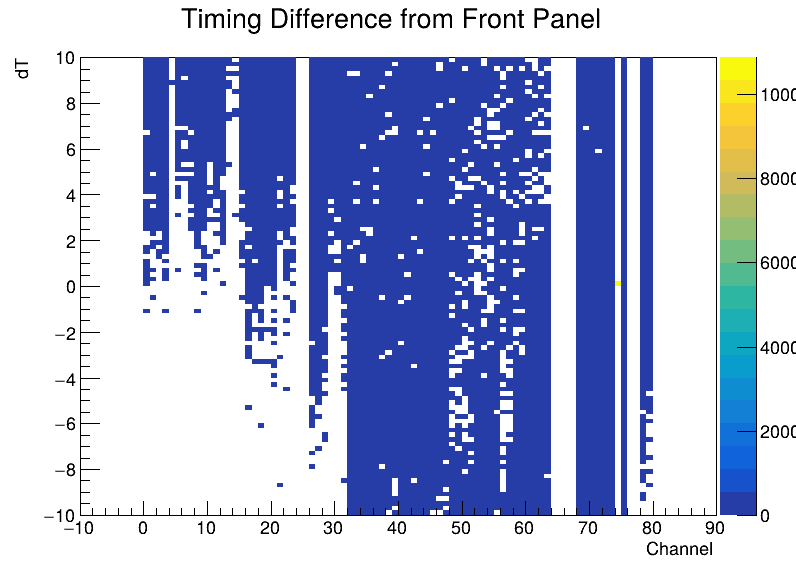

In [85]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas('c1', 'c1', 800, 600)
c1.cd()
h_timeDiff.Draw('colz')
c1.Draw()

In [86]:
h_timeDiffWide.Integral(0, 100, 0, 100)

133860.0

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


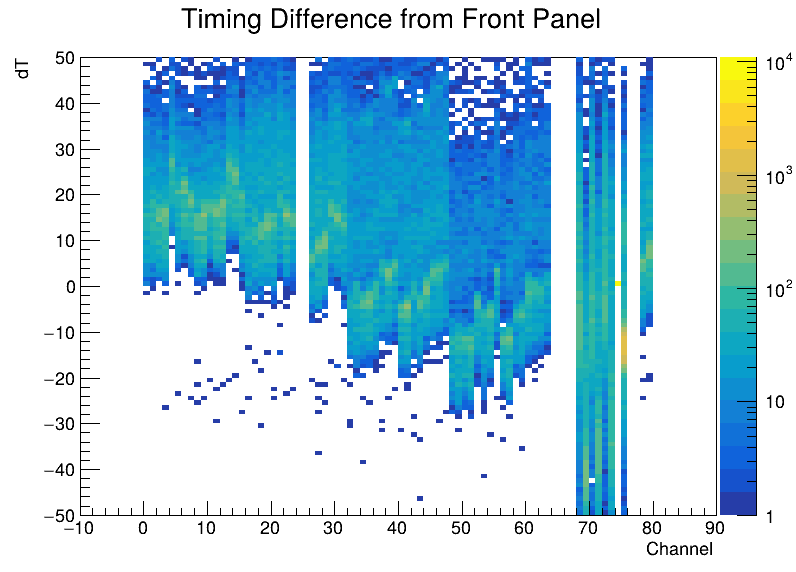

In [87]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas('c1', 'c1', 800, 600)
c1.cd()
h_timeDiffWide.Draw('colz')
c1.Draw()
c1.SetLogz(1)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


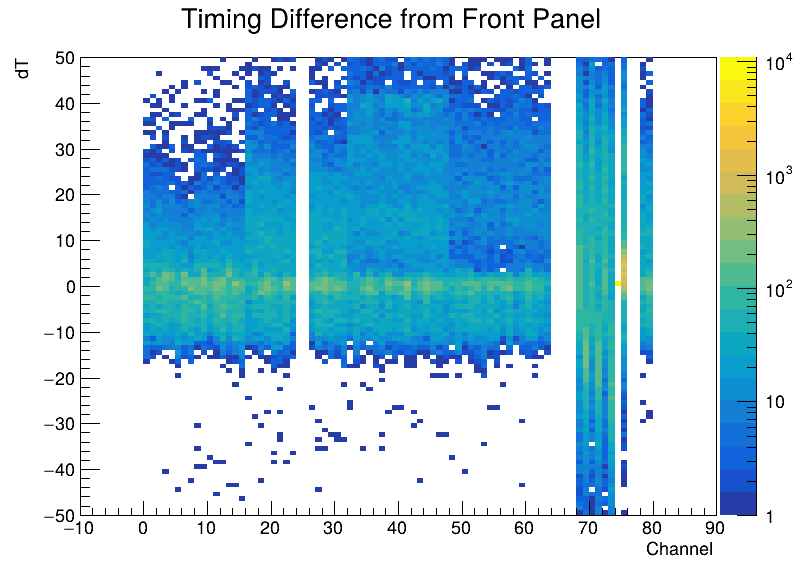

In [88]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas('c1', 'c1', 800, 600)
c1.cd()
h_timeDiffNew.Draw('colz')
c1.Draw()
c1.SetLogz(1)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


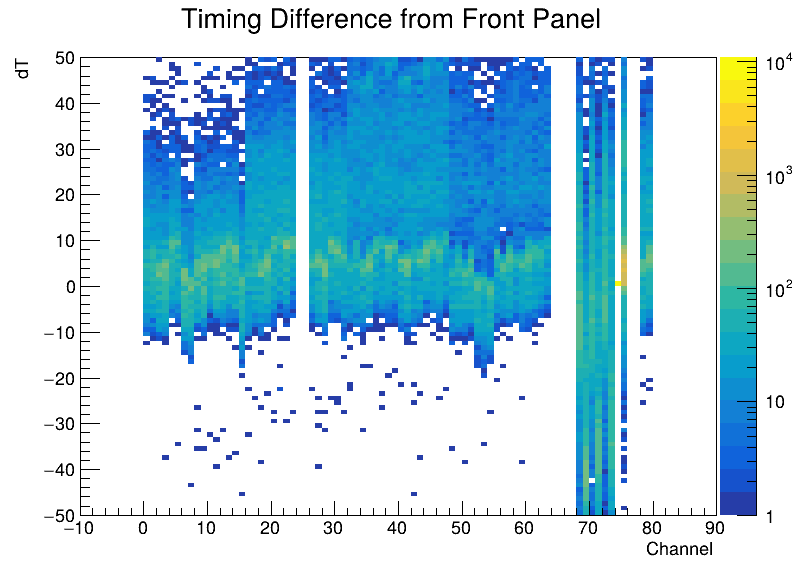

In [89]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas('c1', 'c1', 800, 600)
c1.cd()
h_timeDiffOld.Draw('colz')
c1.Draw()
c1.SetLogz()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


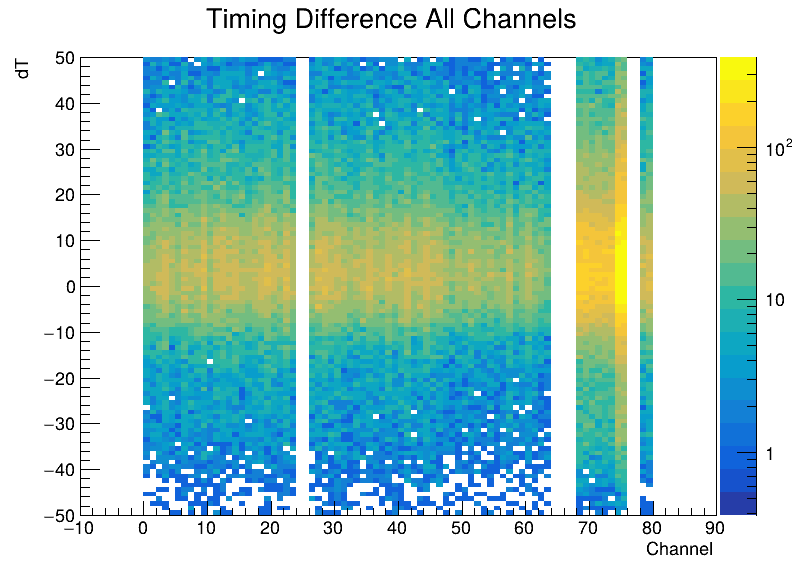

In [90]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas('c1', 'c1', 800, 600)
c1.cd()
h_timeDiffAll.Draw('colz')
c1.Draw()
c1.SetLogz(1)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


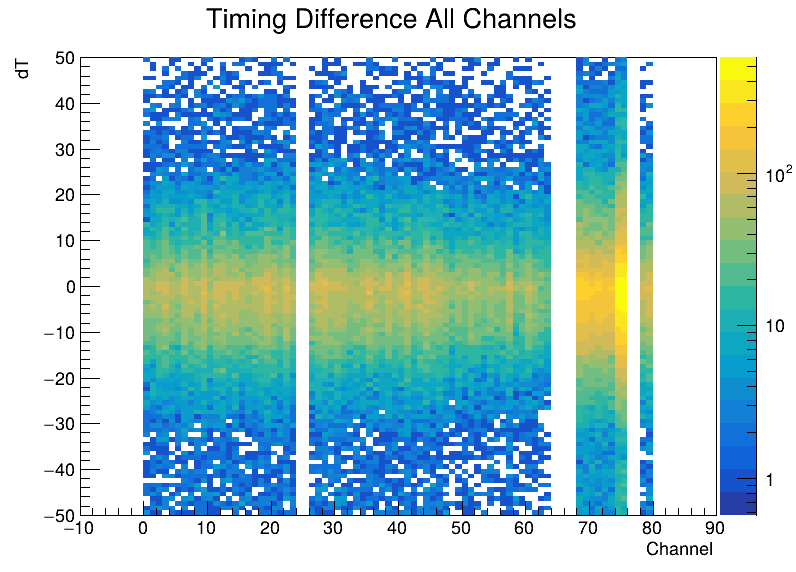

In [91]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas('c1', 'c1', 800, 600)
c1.cd()
h_timeDiffAllNew.Draw('colz')
c1.Draw()
c1.SetLogz(1)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


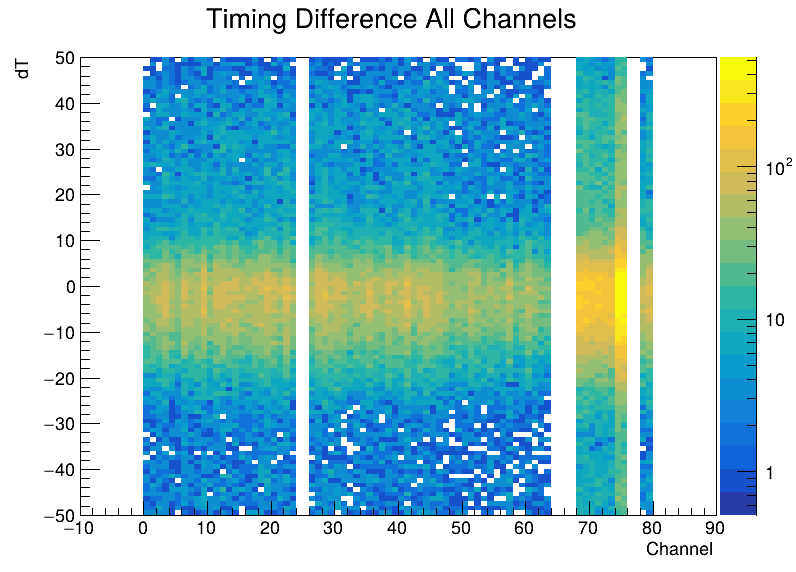

In [92]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas('c1', 'c1', 800, 600)
c1.cd()
h_timeDiffAllOld.Draw('colz')
c1.Draw()
c1.SetLogz()

In [37]:
fin = r.TFile.Open('/eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1800_v35_zeroBias_beamOff_tight.root')
mytree = fin.Get('t')
c1 = r.TCanvas("c1", "c1", 800, 600)
fin.ls()

TNetXNGFile**		root://eospublic.cern.ch//eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1800_v35_zeroBias_beamOff_tight.root	
 TNetXNGFile*		root://eospublic.cern.ch//eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1800_v35_zeroBias_beamOff_tight.root	
  OBJ: TTree	t	t : 0 at: 0x8daf350
  KEY: TTree	t;2	t [current cycle]
  KEY: TTree	t;1	t [backup cycle]
  KEY: TNamed	luminosity;1	0.0
  KEY: TNamed	runTime;1	228916.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


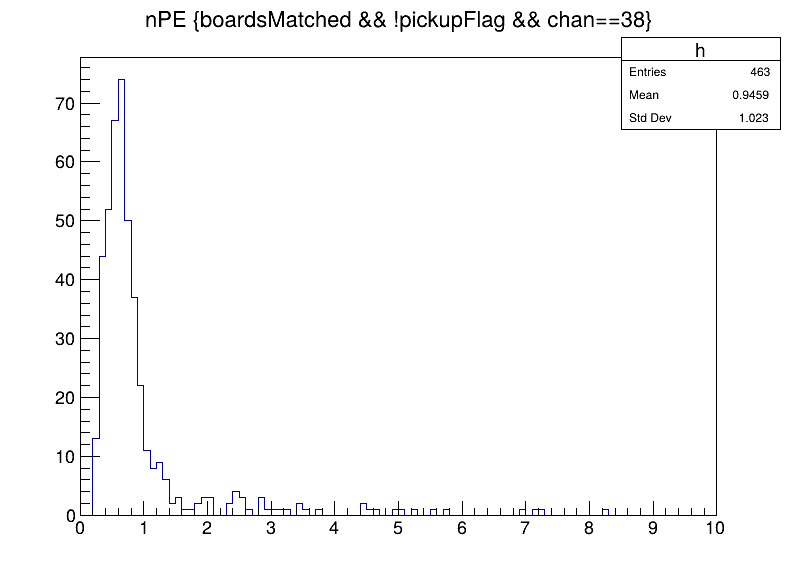

In [50]:
c1.cd()
c1.Clear()
mytree.Draw("nPE>>h(100, 0, 10)", 'boardsMatched && !pickupFlag && chan==38', 'colz')
c1.Draw()
c1.SetLogy(0)

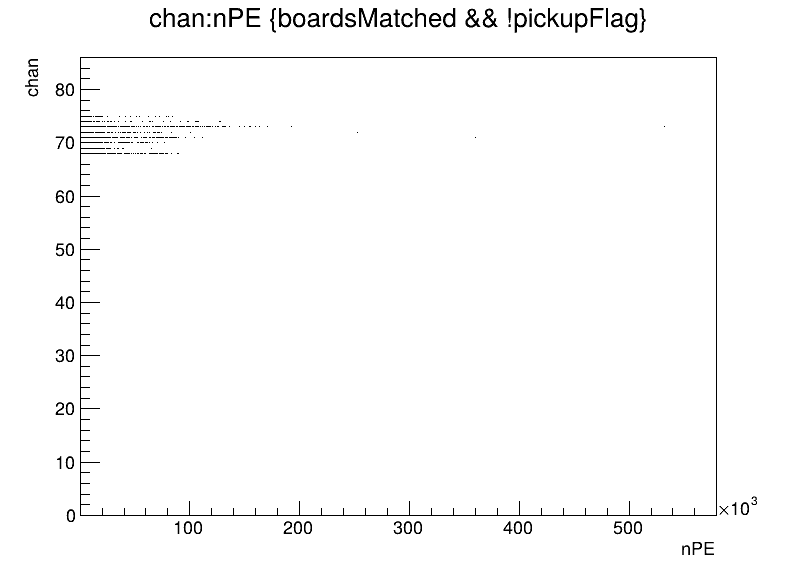

In [40]:
c1.Draw()